In [105]:
import numpy as np
import matplotlib.pyplot as plt
import mkl

mkl.set_num_threads(4)
np.random.seed(1234)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = [16, 9]

from six.moves import urllib    
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

In [106]:
# arrange 2D matrices as tiles (takes 4D `examples` tensor with dims: rows x cols x tile_height x tile_width)
def tiles(examples):
    rows_count = examples.shape[0]
    cols_count = examples.shape[1]
    tile_height = examples.shape[2]
    tile_width = examples.shape[3]
    
    space_between_tiles = 2
    width_offset = tile_width + space_between_tiles
    height_offset = tile_height + space_between_tiles
    
    img_matrix = np.zeros((width_offset * rows_count - space_between_tiles, 
                           height_offset * cols_count - space_between_tiles), dtype=np.float32)
    
    img_matrix.fill(np.nan)
    
    for r in range(0, rows_count):
        for c in range(0, cols_count):
            r_coord = r * width_offset
            c_coord = c * height_offset
            img_matrix[r_coord:r_coord + tile_height, c_coord:c_coord + tile_width] = examples[r, c]

    return img_matrix

## MNIST Dataset

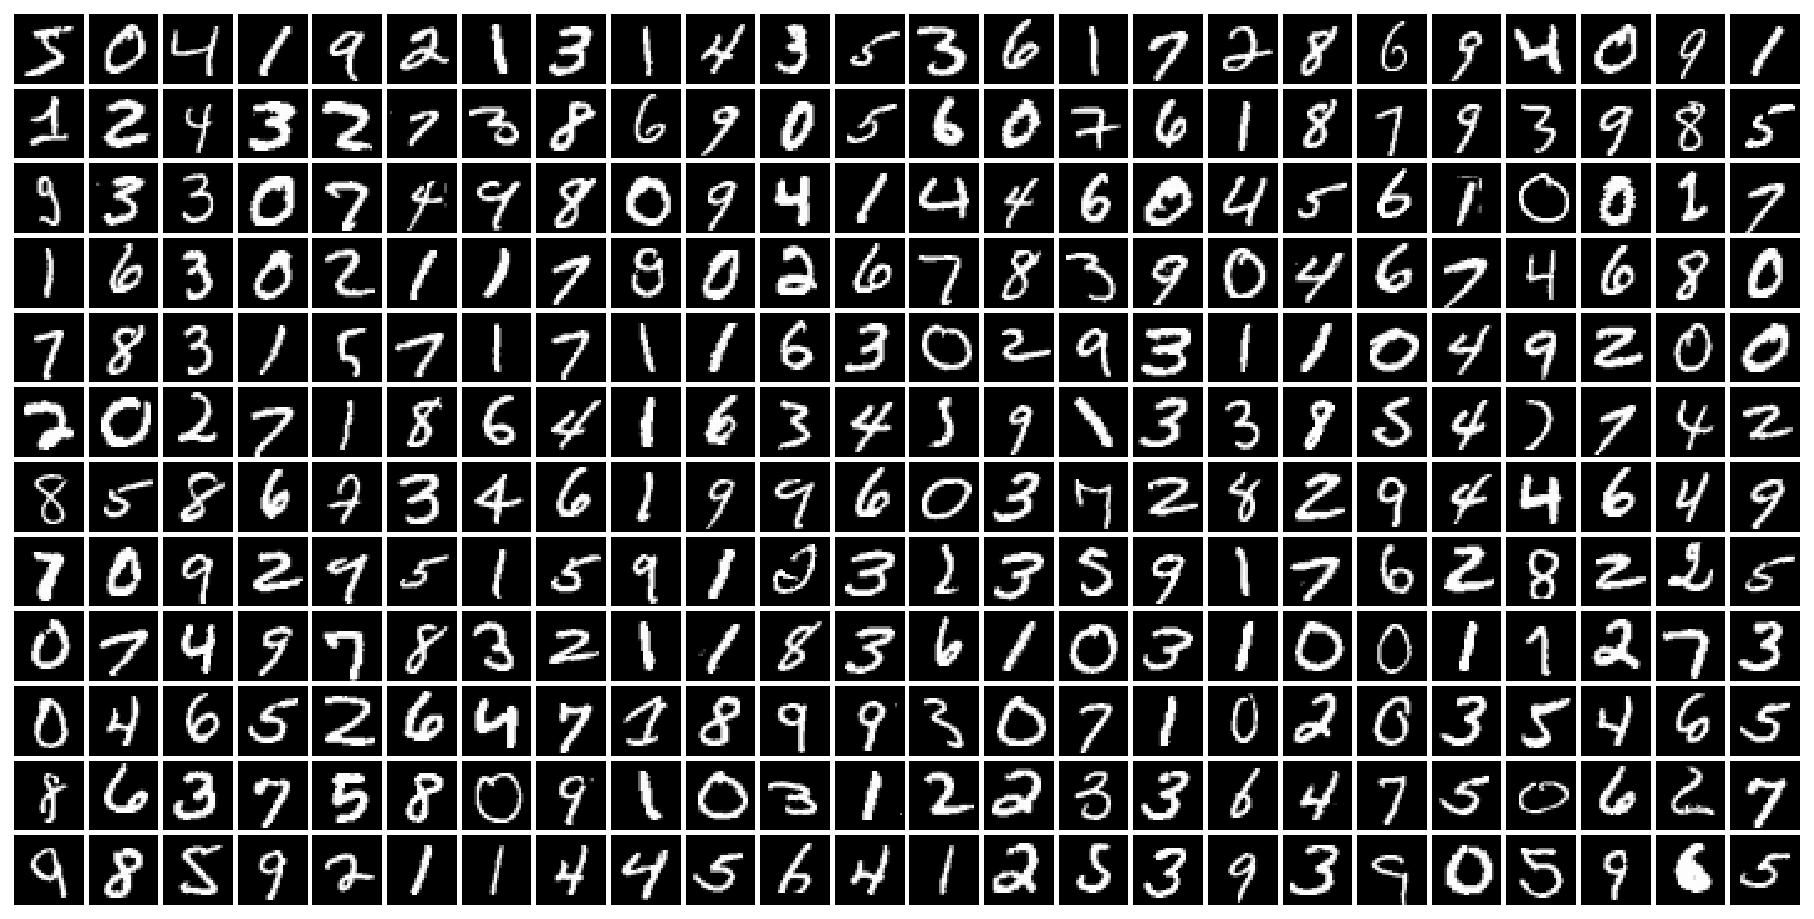

In [107]:
import mnist
digits = np.reshape(mnist.train_images()[:12*24], newshape=(12, 24, 28, 28))
img = tiles(digits)

plt.matshow(img, cmap='gray', interpolation='none')
plt.axis('off')
plt.show()

In [108]:
X = mnist.train_images().astype(np.float32) / 255.0
y = mnist.train_labels()
X.shape

(60000, 28, 28)

Reshape `X` so that the last two dimensions are collapsed into single dimension.

In [109]:
X = X.reshape(60000,28*28)

In [110]:
X.shape

(60000, 784)

## Visualizing the distribution of MNIST digits

Add a scatter plot to `plot`, which:
* displys the first two dimensions of `X`,
* includes only these elements from `X` for which `y == i` (i.e. elements from the i-th class),
* includes label (i.e. `i`) in the legend.


In [116]:
def plot_2d_mnist_scatter(X, y):
    fig, plot = plt.subplots()
    fig.set_size_inches(16, 16)
    plt.prism()

    for i in range(10):
        digit_indices = (y == i)
        dim1 = X[digit_indices][:, 0]
        dim2 = X[digit_indices][:, 1]
        plot.scatter(dim1, dim2, label=i)
        

    plot.set_xticks(())
    plot.set_yticks(())

    plt.tight_layout()
    plt.legend()
    plt.show()

### Principal Component Analysis (PCA)

In [117]:
SAMPLES_LIMIT = 2000
X_small = X[:SAMPLES_LIMIT]
y_small = y[:SAMPLES_LIMIT]

Use PCA function to embed `X_small` in two dimensions. Store the result in `X_pca_embedded`.

In [118]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca_embedded = pca.fit_transform(X_small, y_small)

In [119]:
X_pca_embedded.shape

(2000, 2)

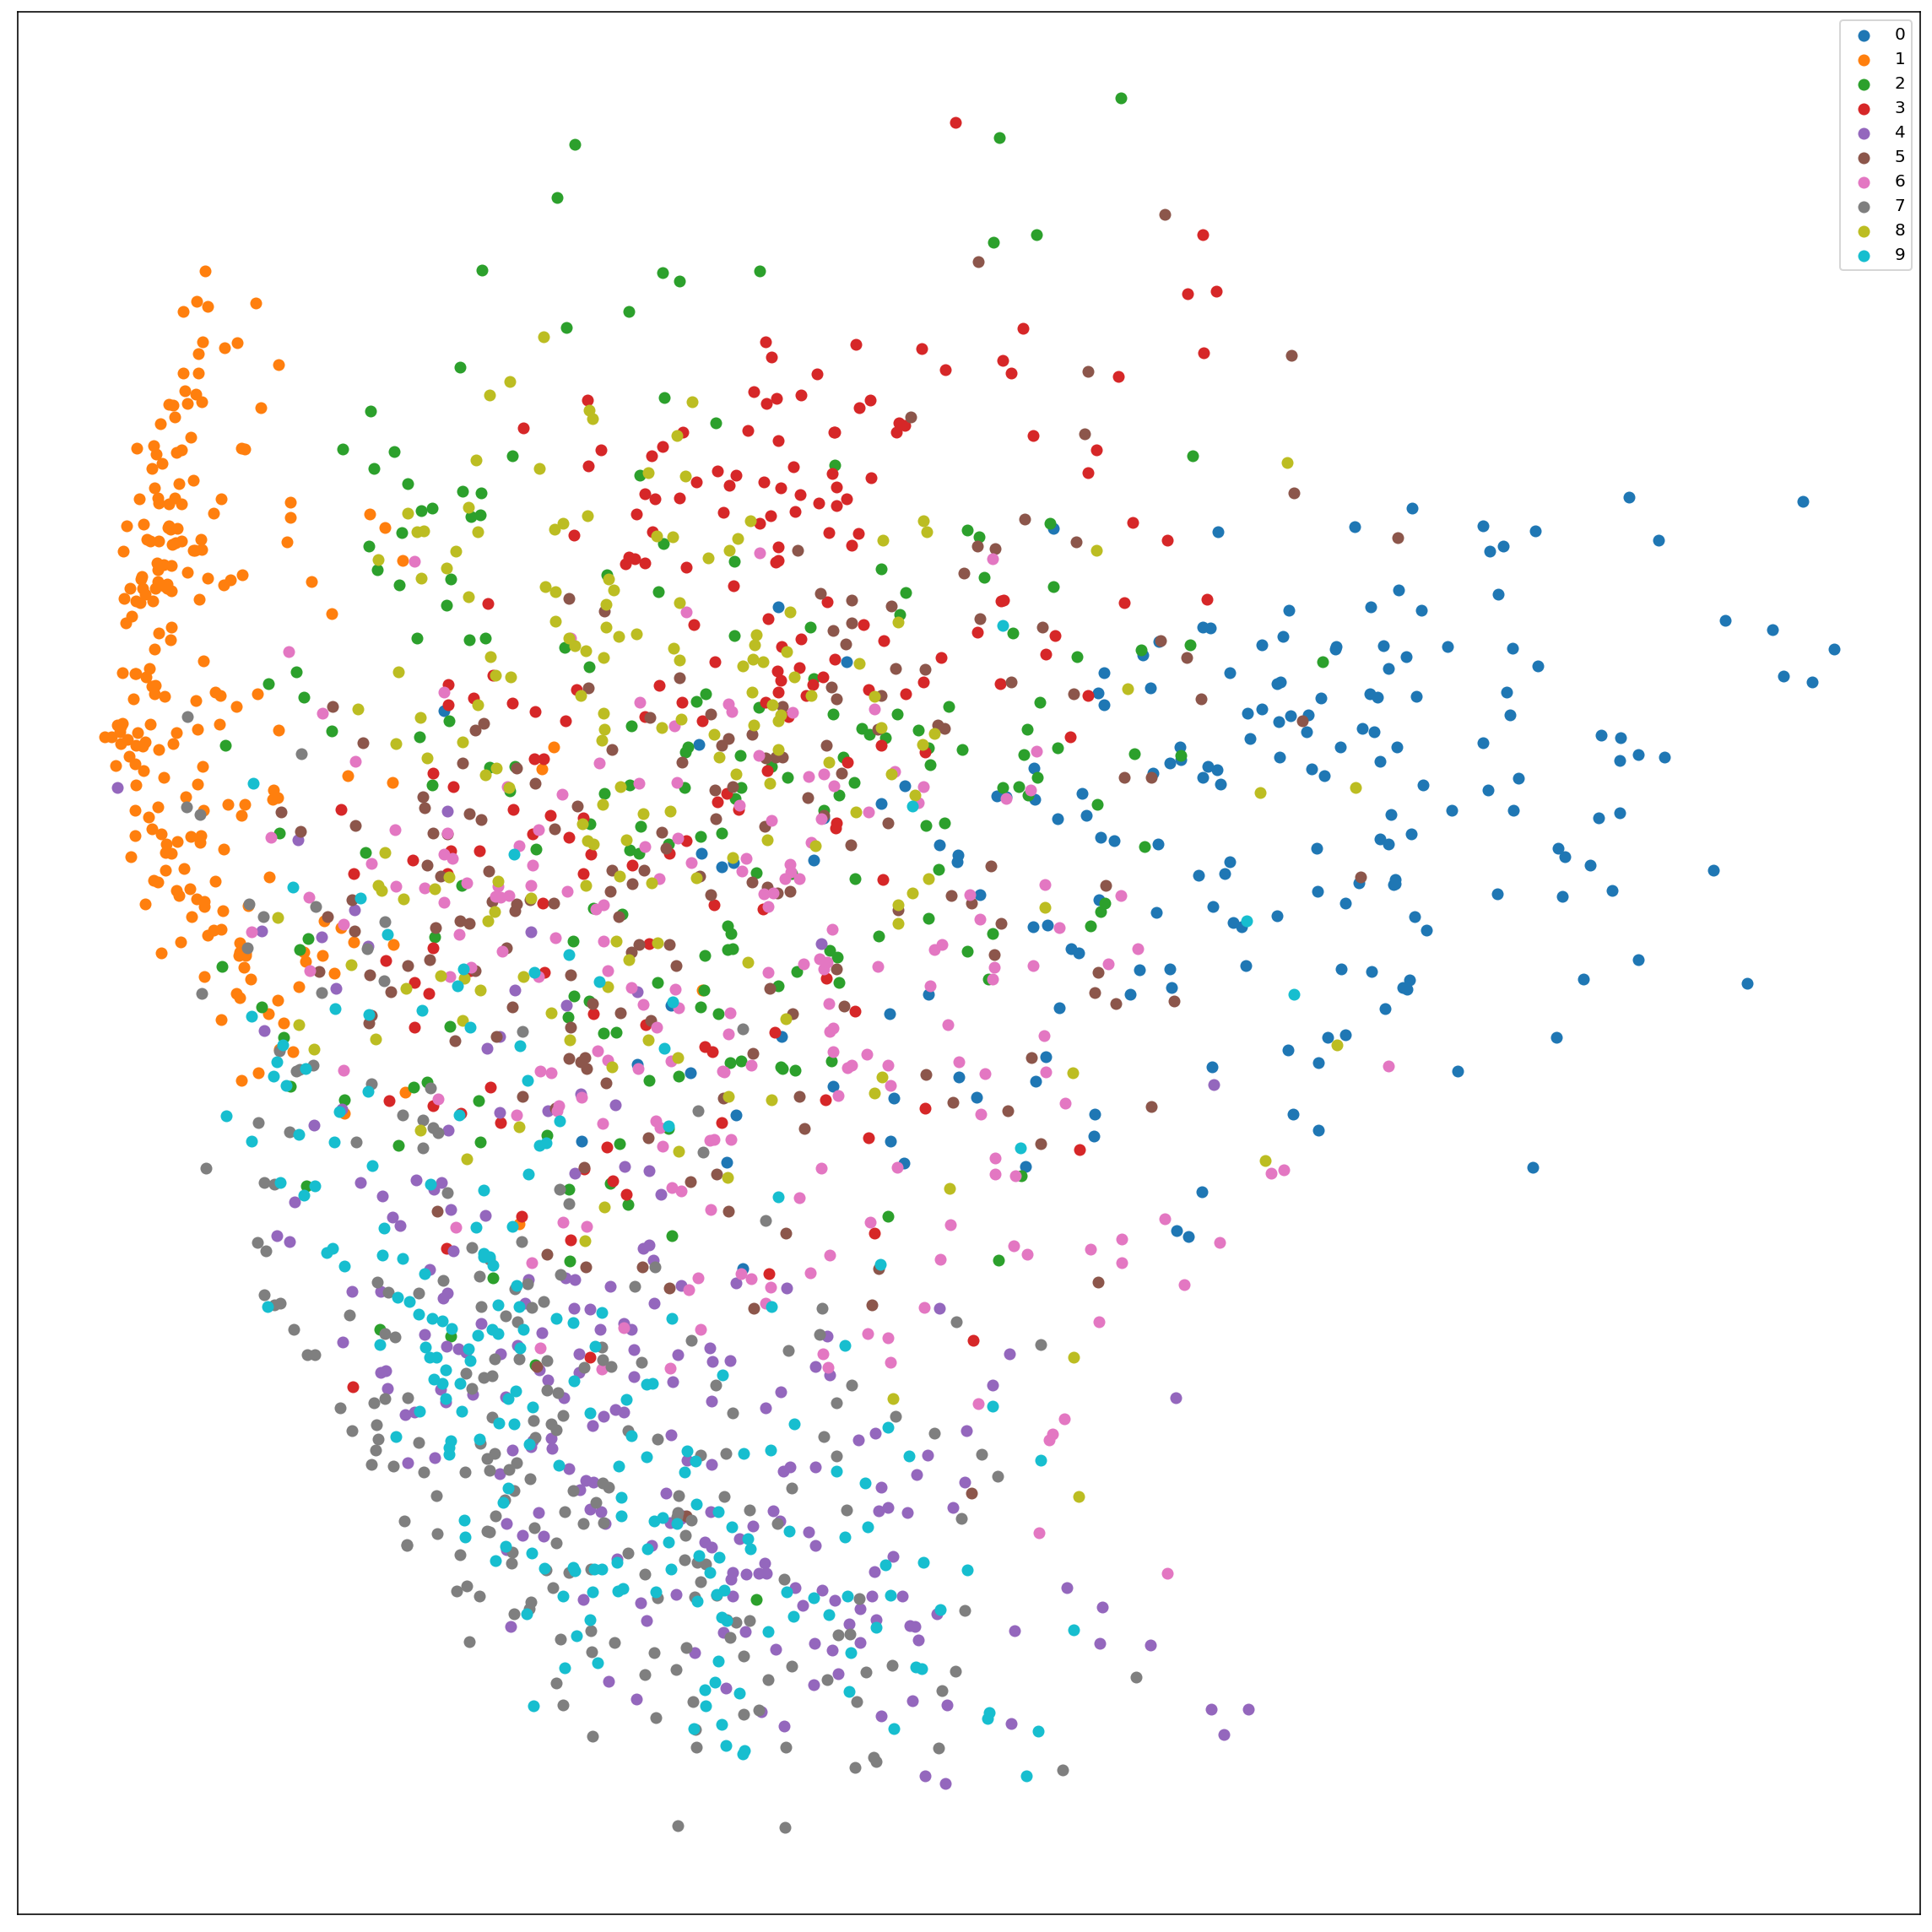

In [120]:
plot_2d_mnist_scatter(X_pca_embedded, y_small)

### T-distributed Stochastic Neighbour Embedding (T-SNE)

Make sure to have a look on this increadible [article on T-SNE](https://distill.pub/2016/misread-tsne/).

Use `T-SNE` function to embed `X_small` in two dimensions. Store the result in `X_tsne_embedded`. <BR>
Use:
 * `n_iter=500` argument to limit the number of T-SNE iterations, 
 * `verbose=2` argument to see a verbose output during embedding.

In [121]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, n_iter=500, verbose=2)
X_tsne_embedded = tsne.fit_transform(X_small)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.001s...
[t-SNE] Computed neighbors for 2000 samples in 0.126s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 2.528206
[t-SNE] Computed conditional probabilities in 0.074s
[t-SNE] Iteration 50: error = 78.0281448, gradient norm = 0.0123441 (50 iterations in 0.330s)
[t-SNE] Iteration 100: error = 76.2105255, gradient norm = 0.0280876 (50 iterations in 0.275s)
[t-SNE] Iteration 150: error = 75.6754913, gradient norm = 0.0020169 (50 iterations in 0.233s)
[t-SNE] Iteration 200: error = 75.6743546, gradient norm = 0.0023520 (50 iterations in 0.238s)
[t-SNE] Iteration 250: error = 75.6667862, gradient norm = 0.0055069 (50 iterations in 0.250s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.666786
[t-SNE] Iteration 300: error = 1.4881059, gradient norm = 0.0010999 (50 iterations in 0.253s)

In [122]:
X_tsne_embedded.shape

(2000, 2)

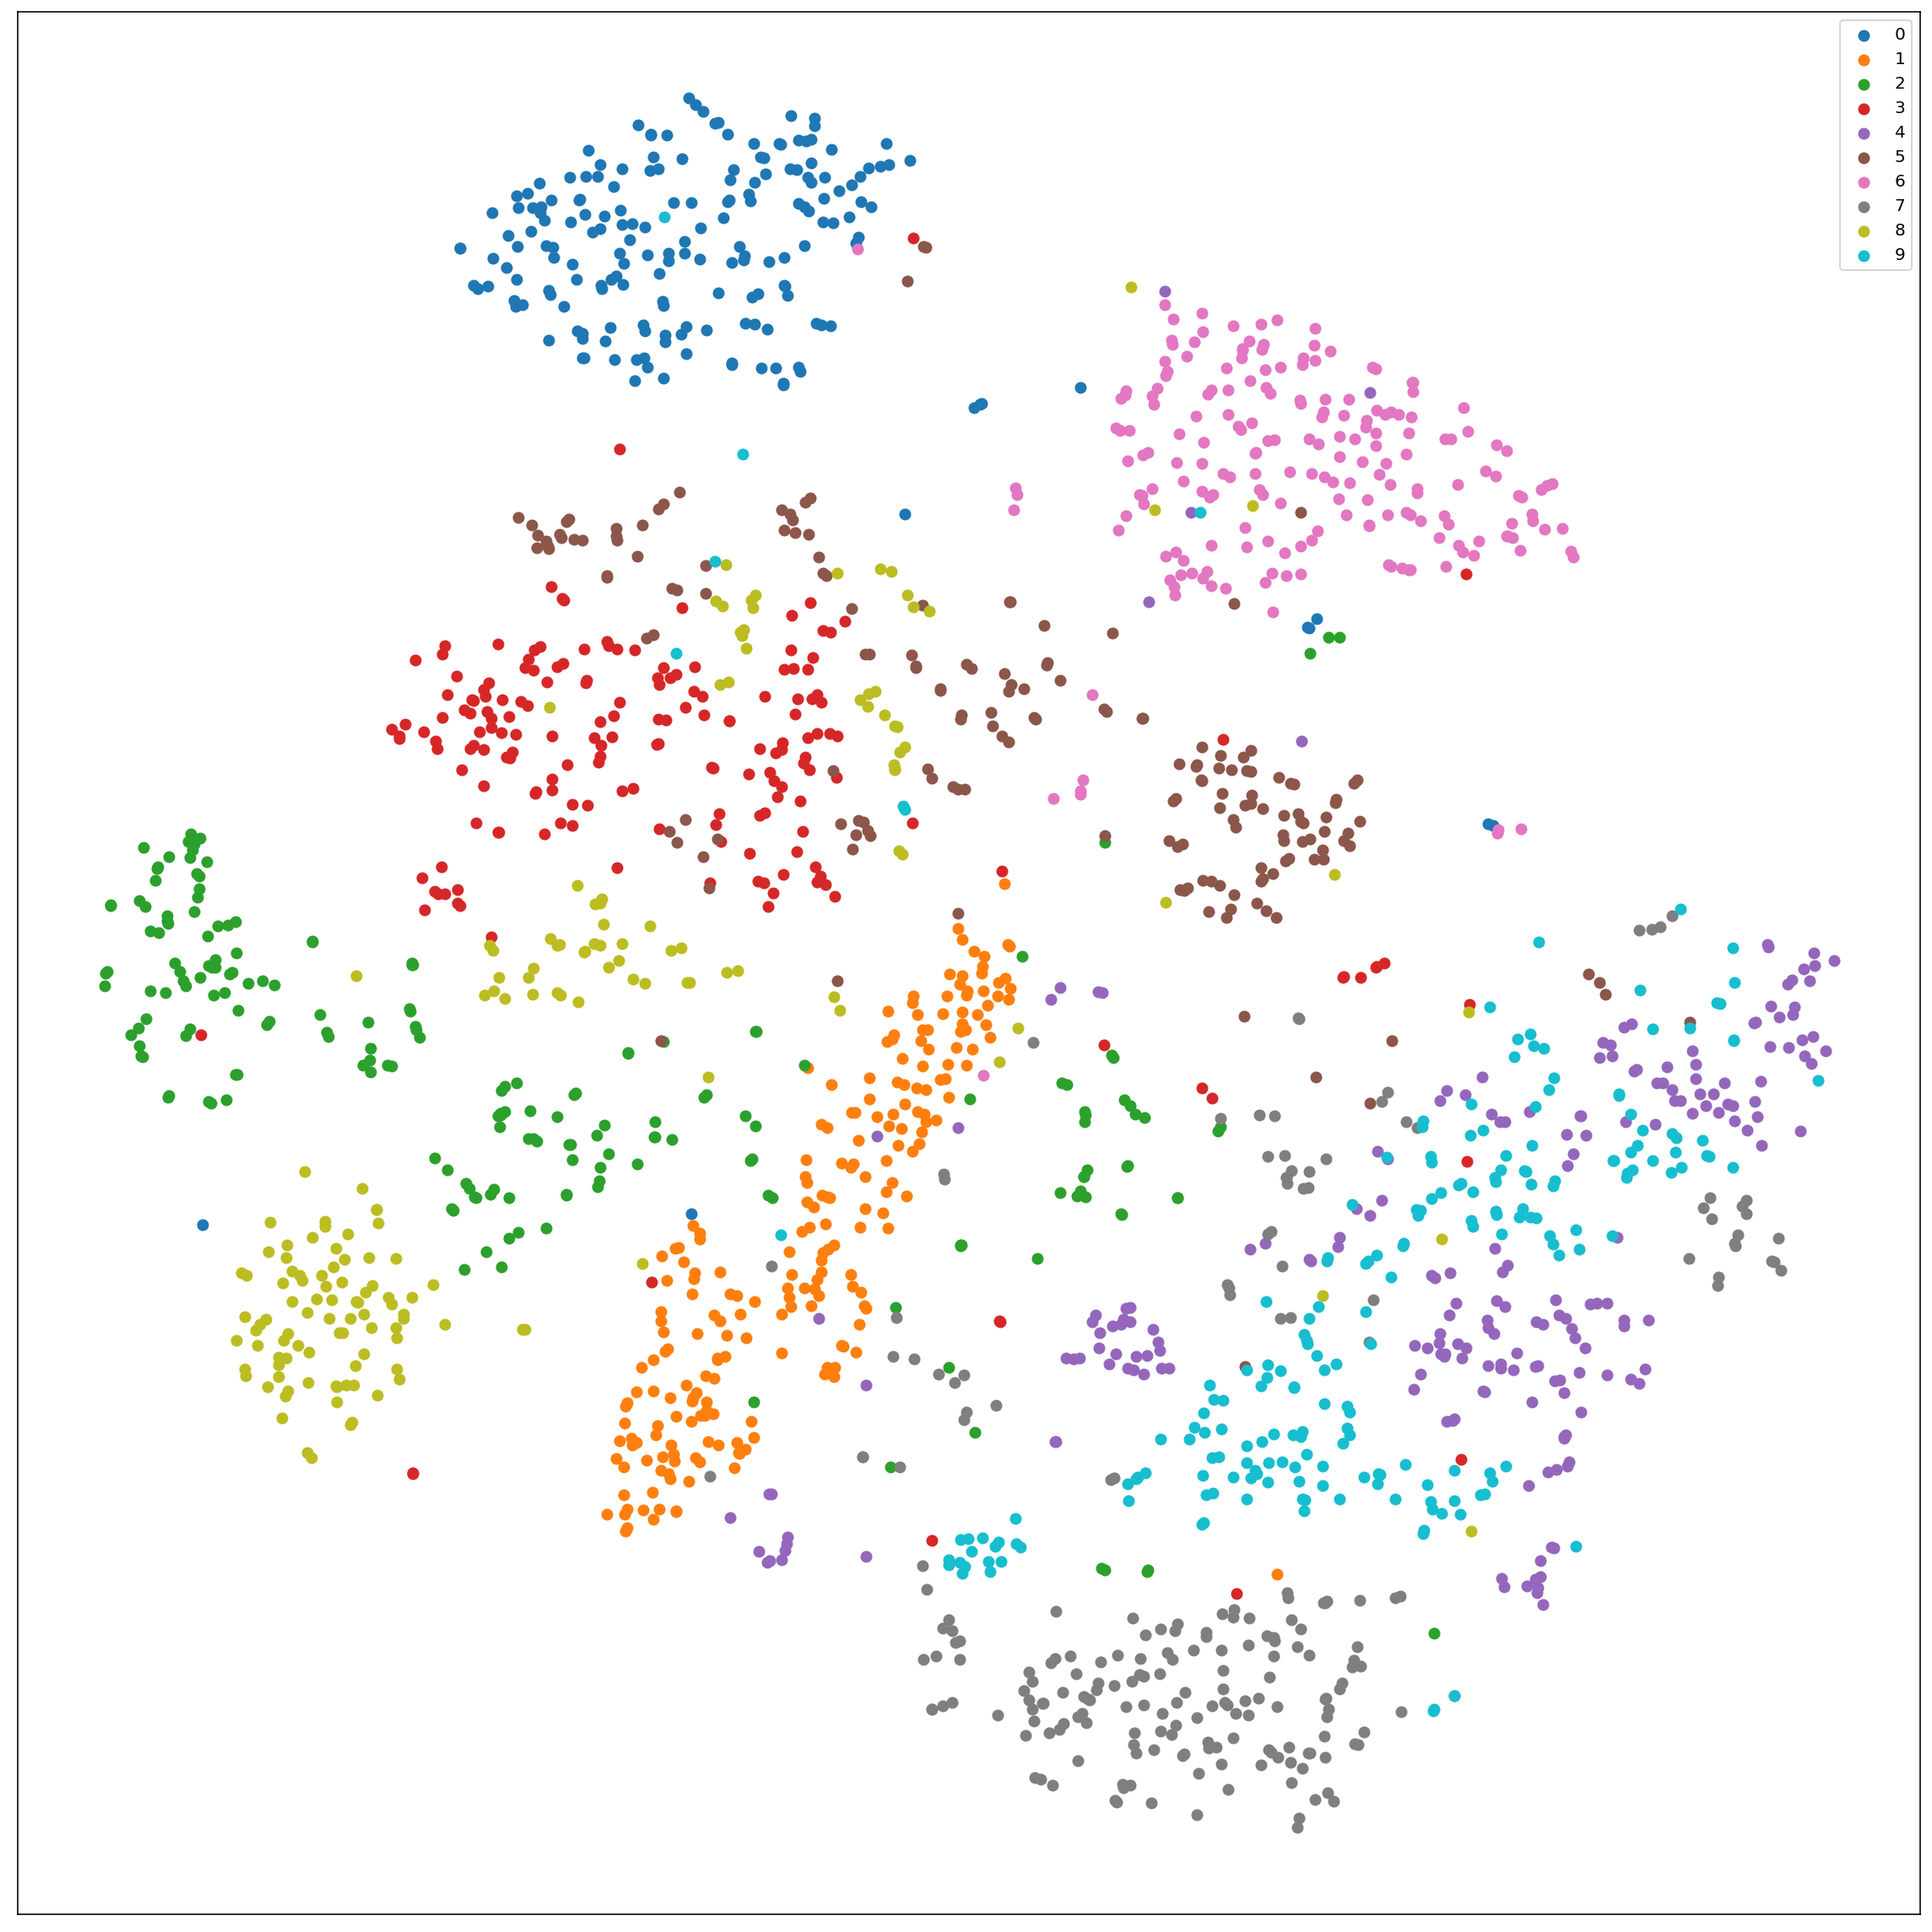

In [128]:
plot_2d_mnist_scatter(X_tsne_embedded, y_small)

### 3D interactive plots with plotly

In [136]:
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

init_notebook_mode(connected=True)

def plot_3d_mnist_plotly_scatter(X, y):
    def make_trace(i):
        digit_indeces = y == i
        return go.Scatter3d(
            x=X[digit_indeces, 0],
            y=X[digit_indeces, 1],
            z=X[digit_indeces, 2],
            mode='markers',
            name=str(i),
            marker=dict(
                color=i,
                colorscale='Jet',
                size=4,
                symbol='circle',
                line=dict(
                    color='rgb(204, 204, 204)',
                    width=1
                )
            )
        )
        
    traces = [make_trace(i) for i in range(10)]
    
    layout = go.Layout(margin=dict(l=0, r=0, b=0, t=0))
    fig = go.Figure(data=traces, layout=layout)
    iplot(fig)

Use PCA function to embed `X_small` in **three** dimensions. Store the result in `X_3d_pca_embedded`.

In [144]:
pca_3d = PCA(n_components=3)
X_3d_pca_embedded = pca_3d.fit_transform(X_small, y_small)

In [145]:
X_3d_pca_embedded.shape

(2000, 3)

In [146]:
plot_3d_mnist_plotly_scatter(X_3d_pca_embedded, y_small)

## Classification task

In [130]:
from sklearn.model_selection import train_test_split
SAMPLES_LIMIT=10000
X_train, X_test, y_train, y_test = train_test_split(X[:SAMPLES_LIMIT], y[:SAMPLES_LIMIT], test_size=0.2)

In [131]:
from sklearn import svm
classifier = svm.SVC(C=1, gamma=0.001)
classifier.fit(X_train, y_train)

SVC(C=1, gamma=0.001)

In [132]:
from sklearn import metrics

predicted = classifier.predict(X_test)

print("Classification report for classifier {}:\n{}\n".format(
    classifier, metrics.classification_report(y_test, predicted)))

Classification report for classifier SVC(C=1, gamma=0.001):
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       207
           1       0.90      0.98      0.94       236
           2       0.90      0.90      0.90       171
           3       0.89      0.91      0.90       227
           4       0.87      0.94      0.90       196
           5       0.88      0.82      0.85       166
           6       0.94      0.94      0.94       177
           7       0.92      0.89      0.90       236
           8       0.94      0.84      0.88       188
           9       0.89      0.87      0.88       196

    accuracy                           0.91      2000
   macro avg       0.91      0.90      0.90      2000
weighted avg       0.91      0.91      0.91      2000




Calculate and display the confision matrix for `predicted` and `y_test` (use metrics package).

In [134]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, predicted)

print("Confusion matrix:\n{}".format(confusion_matrix))

Confusion matrix:
[[200   0   1   2   0   1   0   1   2   0]
 [  0 231   0   2   0   2   0   1   0   0]
 [  1   5 154   1   2   1   3   2   1   1]
 [  1   3   4 206   0   6   0   4   1   2]
 [  0   2   1   0 184   0   0   3   0   6]
 [  2   4   2   9   3 136   5   0   4   1]
 [  2   0   2   0   5   1 166   0   1   0]
 [  1   9   4   0   6   0   0 209   1   6]
 [  4   4   2   4   4   7   2   0 157   4]
 [  3   0   2   8   7   0   0   6   0 170]]
